In [1]:
import numpy as np
import sys
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv2D, Flatten, BatchNormalization, Activation, MaxPooling2D
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from tqdm import tqdm
import pyaudio
import scipy.io.wavfile as wav
import os
import speechpy
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pydot
from sklearn.preprocessing import LabelEncoder
import pandas as pd

Using TensorFlow backend.


In [2]:
models = ["CNN"]
dataset_folder = "/home/vishnu/NN/Data"
class_labels = ["Angry", "Disgust", "Fear", "Happiness", "Neutral", "Sadness", "Surprise"]
mslen = 32000  # Empirically calculated for the given dataset

In [3]:
def read_wav(filename):
    return wav.read(filename)

In [4]:
def get_data(flatten=True, mfcc_len=39):
    data = []
    labels = []
    max_fs = 0
    cnt = 0
    cur_dir = os.getcwd()
    os.chdir('..')
    os.chdir(dataset_folder)
    for i, directory in enumerate(class_labels):
        print ("started reading folder", directory)
        os.chdir(directory)
        for filename in os.listdir('.'):
            fs, signal = read_wav(filename)
            max_fs = max(max_fs, fs)
            s_len = len(signal)
            #Padding the signal to have the same size
            if s_len < mslen:
                pad_len = mslen - s_len
                pad_rem = pad_len % 2
                pad_len /= 2
                signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values=0)
            else:
                pad_len = s_len - mslen
                pad_rem = pad_len % 2
                pad_len /= 2
                signal = signal[int(pad_len):int(pad_len) + mslen]
            mfcc = speechpy.feature.mfcc(signal, fs, num_cepstral=mfcc_len)

            if flatten:
                # Flatten the data
                mfcc = mfcc.flatten()
            data.append(mfcc)
            labels.append(i)
            cnt += 1
        print ("ended reading folder", directory)
        os.chdir('..')
    os.chdir(cur_dir)
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [5]:
def get_model(model_name, input_shape):
    model = Sequential()
    model.add(Conv2D(8, (13, 13), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (13, 13)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(8, (13, 13)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(class_labels), activation='softmax'))
    #model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# Read data
global x_train, y_train, x_test, y_test
x_train, x_test, y_train, y_test = get_data(flatten=False)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

started reading folder Angry
ended reading folder Angry
started reading folder Disgust
ended reading folder Disgust
started reading folder Fear
ended reading folder Fear
started reading folder Happiness
ended reading folder Happiness
started reading folder Neutral
ended reading folder Neutral
started reading folder Sadness
ended reading folder Sadness
started reading folder Surprise
ended reading folder Surprise


In [7]:
# Model is CNN so have to reshape the data
in_shape = x_train[0].shape
x_train = x_train.reshape(x_train.shape[0], in_shape[0], in_shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], in_shape[0], in_shape[1], 1)

In [8]:
model = get_model(models[0], x_train[0].shape)

global best_model_path
best_model_path = '/home/vishnu/NN/model_' + models[0] + '.h5'

#evaluateModel(model)

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 27, 8)         1360      
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 27, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 58, 27, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 15, 8)         10824     
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 15, 8)         32        
_________________________________________________________________
activation_2 (Activation)    (None, 46, 15, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 15, 8)         0         
__________

In [10]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
cnnhistory=model.fit(x_train, y_train, batch_size=32, epochs=500, validation_data=(x_test, y_test))

Train on 384 samples, validate on 96 samples
Epoch 1/500
384/384 [==============================] - 5s 13ms/step - loss: 0.4646 - acc: 0.8423 - val_loss: 0.5734 - val_acc: 0.8170
Epoch 2/500
384/384 [==============================] - 4s 12ms/step - loss: 0.3584 - acc: 0.8635 - val_loss: 0.5928 - val_acc: 0.8125
Epoch 3/500
384/384 [==============================] - 4s 10ms/step - loss: 0.2973 - acc: 0.8802 - val_loss: 0.4710 - val_acc: 0.8438
Epoch 4/500
384/384 [==============================] - 4s 9ms/step - loss: 0.2573 - acc: 0.9014 - val_loss: 0.4172 - val_acc: 0.8527
Epoch 5/500
384/384 [==============================] - 4s 9ms/step - loss: 0.2080 - acc: 0.9174 - val_loss: 0.4235 - val_acc: 0.8497
Epoch 6/500
384/384 [==============================] - 4s 9ms/step - loss: 0.1827 - acc: 0.9297 - val_loss: 0.4236 - val_acc: 0.8452
Epoch 7/500
384/384 [==============================] - 4s 9ms/step - loss: 0.1512 - acc: 0.9498 - val_loss: 0.4264 - val_acc: 0.8393
Epoch 8/500
384/384 [

384/384 [==============================] - 4s 11ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5998 - val_acc: 0.8095
Epoch 62/500
384/384 [==============================] - 4s 11ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.5980 - val_acc: 0.8140
Epoch 63/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5910 - val_acc: 0.8170
Epoch 64/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.6161 - val_acc: 0.8036
Epoch 65/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.6204 - val_acc: 0.8095
Epoch 66/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.6229 - val_acc: 0.8036
Epoch 67/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5964 - val_acc: 0.8036
Epoch 68/500
384/384 [==============================] - 4s 10ms/step

384/384 [==============================] - 4s 11ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.6296 - val_acc: 0.7976
Epoch 122/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.6291 - val_acc: 0.7961
Epoch 123/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.6255 - val_acc: 0.7976
Epoch 124/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.6248 - val_acc: 0.8036
Epoch 125/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.6245 - val_acc: 0.8021
Epoch 126/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.6274 - val_acc: 0.8021
Epoch 127/500
384/384 [==============================] - 4s 10ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.6341 - val_acc: 0.8065
Epoch 128/500
384/384 [==============================] - 4s 10

384/384 [==============================] - 4s 10ms/step - loss: 4.5838e-04 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 0.7991
Epoch 181/500
384/384 [==============================] - 4s 10ms/step - loss: 4.3771e-04 - acc: 1.0000 - val_loss: 0.6840 - val_acc: 0.8021
Epoch 182/500
384/384 [==============================] - 4s 10ms/step - loss: 5.3262e-04 - acc: 1.0000 - val_loss: 0.6846 - val_acc: 0.8021
Epoch 183/500
384/384 [==============================] - 4s 10ms/step - loss: 6.5527e-04 - acc: 1.0000 - val_loss: 0.6840 - val_acc: 0.8051
Epoch 184/500
384/384 [==============================] - 4s 10ms/step - loss: 4.2825e-04 - acc: 1.0000 - val_loss: 0.6835 - val_acc: 0.8051
Epoch 185/500
384/384 [==============================] - 4s 10ms/step - loss: 4.6185e-04 - acc: 1.0000 - val_loss: 0.6843 - val_acc: 0.8036
Epoch 186/500
384/384 [==============================] - 4s 10ms/step - loss: 4.0951e-04 - acc: 1.0000 - val_loss: 0.6844 - val_acc: 0.8036
Epoch 187/500
384/384 [===========

384/384 [==============================] - 4s 10ms/step - loss: 1.5787e-04 - acc: 1.0000 - val_loss: 0.7380 - val_acc: 0.8021
Epoch 239/500
384/384 [==============================] - 4s 11ms/step - loss: 1.4225e-04 - acc: 1.0000 - val_loss: 0.7373 - val_acc: 0.8006
Epoch 240/500
384/384 [==============================] - 4s 10ms/step - loss: 1.6386e-04 - acc: 1.0000 - val_loss: 0.7370 - val_acc: 0.8006
Epoch 241/500
384/384 [==============================] - 4s 10ms/step - loss: 1.8731e-04 - acc: 1.0000 - val_loss: 0.7365 - val_acc: 0.7991
Epoch 242/500
384/384 [==============================] - 4s 11ms/step - loss: 1.9866e-04 - acc: 1.0000 - val_loss: 0.7363 - val_acc: 0.7991
Epoch 243/500
384/384 [==============================] - 4s 10ms/step - loss: 1.6900e-04 - acc: 1.0000 - val_loss: 0.7362 - val_acc: 0.8006
Epoch 244/500
384/384 [==============================] - 4s 10ms/step - loss: 1.6443e-04 - acc: 1.0000 - val_loss: 0.7348 - val_acc: 0.8006
Epoch 245/500
384/384 [===========

384/384 [==============================] - 4s 10ms/step - loss: 1.4653e-04 - acc: 1.0000 - val_loss: 0.7375 - val_acc: 0.7961
Epoch 297/500
384/384 [==============================] - 4s 10ms/step - loss: 1.0778e-04 - acc: 1.0000 - val_loss: 0.7393 - val_acc: 0.7961
Epoch 298/500
384/384 [==============================] - 4s 10ms/step - loss: 1.5933e-04 - acc: 1.0000 - val_loss: 0.7419 - val_acc: 0.7961
Epoch 299/500
384/384 [==============================] - 4s 11ms/step - loss: 1.9889e-04 - acc: 1.0000 - val_loss: 0.7474 - val_acc: 0.7946
Epoch 300/500
384/384 [==============================] - 4s 10ms/step - loss: 1.2721e-04 - acc: 1.0000 - val_loss: 0.7515 - val_acc: 0.7991
Epoch 301/500
384/384 [==============================] - 4s 10ms/step - loss: 1.1686e-04 - acc: 1.0000 - val_loss: 0.7552 - val_acc: 0.7976
Epoch 302/500
384/384 [==============================] - 4s 10ms/step - loss: 1.7019e-04 - acc: 1.0000 - val_loss: 0.7587 - val_acc: 0.7991
Epoch 303/500
384/384 [===========

384/384 [==============================] - 4s 10ms/step - loss: 1.2392e-04 - acc: 1.0000 - val_loss: 0.7723 - val_acc: 0.7991
Epoch 355/500
384/384 [==============================] - 4s 10ms/step - loss: 1.1025e-04 - acc: 1.0000 - val_loss: 0.7726 - val_acc: 0.7976
Epoch 356/500
384/384 [==============================] - 4s 10ms/step - loss: 6.4427e-05 - acc: 1.0000 - val_loss: 0.7723 - val_acc: 0.7961
Epoch 357/500
384/384 [==============================] - 4s 10ms/step - loss: 7.5475e-05 - acc: 1.0000 - val_loss: 0.7734 - val_acc: 0.7961
Epoch 358/500
384/384 [==============================] - 4s 11ms/step - loss: 1.2690e-04 - acc: 1.0000 - val_loss: 0.7719 - val_acc: 0.8021
Epoch 359/500
384/384 [==============================] - 4s 10ms/step - loss: 2.9454e-04 - acc: 1.0000 - val_loss: 0.7761 - val_acc: 0.7961
Epoch 360/500
384/384 [==============================] - 4s 10ms/step - loss: 7.5879e-05 - acc: 1.0000 - val_loss: 0.7799 - val_acc: 0.7976
Epoch 361/500
384/384 [===========

384/384 [==============================] - 4s 10ms/step - loss: 4.6947e-05 - acc: 1.0000 - val_loss: 0.8174 - val_acc: 0.7932
Epoch 413/500
384/384 [==============================] - 4s 10ms/step - loss: 5.4283e-05 - acc: 1.0000 - val_loss: 0.8170 - val_acc: 0.7946
Epoch 414/500
384/384 [==============================] - 4s 10ms/step - loss: 4.2484e-05 - acc: 1.0000 - val_loss: 0.8183 - val_acc: 0.7961
Epoch 415/500
384/384 [==============================] - 4s 10ms/step - loss: 4.5516e-05 - acc: 1.0000 - val_loss: 0.8190 - val_acc: 0.7961
Epoch 416/500
384/384 [==============================] - 4s 10ms/step - loss: 5.6610e-05 - acc: 1.0000 - val_loss: 0.8199 - val_acc: 0.7932
Epoch 417/500
384/384 [==============================] - 4s 10ms/step - loss: 6.1985e-05 - acc: 1.0000 - val_loss: 0.8240 - val_acc: 0.7932
Epoch 418/500
384/384 [==============================] - 4s 11ms/step - loss: 4.0538e-05 - acc: 1.0000 - val_loss: 0.8261 - val_acc: 0.7917
Epoch 419/500
384/384 [===========

384/384 [==============================] - 5s 14ms/step - loss: 5.1490e-05 - acc: 1.0000 - val_loss: 0.8577 - val_acc: 0.7961
Epoch 471/500
384/384 [==============================] - 4s 11ms/step - loss: 4.9520e-05 - acc: 1.0000 - val_loss: 0.8626 - val_acc: 0.7946
Epoch 472/500
384/384 [==============================] - 4s 10ms/step - loss: 3.6768e-05 - acc: 1.0000 - val_loss: 0.8638 - val_acc: 0.7961
Epoch 473/500
384/384 [==============================] - 4s 10ms/step - loss: 3.3473e-05 - acc: 1.0000 - val_loss: 0.8628 - val_acc: 0.7961
Epoch 474/500
384/384 [==============================] - 4s 10ms/step - loss: 4.2100e-05 - acc: 1.0000 - val_loss: 0.8578 - val_acc: 0.7976
Epoch 475/500
384/384 [==============================] - 4s 10ms/step - loss: 6.4634e-05 - acc: 1.0000 - val_loss: 0.8574 - val_acc: 0.7976
Epoch 476/500
384/384 [==============================] - 4s 10ms/step - loss: 3.5123e-05 - acc: 1.0000 - val_loss: 0.8588 - val_acc: 0.7946
Epoch 477/500
384/384 [===========

In [12]:
import matplotlib.pyplot as plt

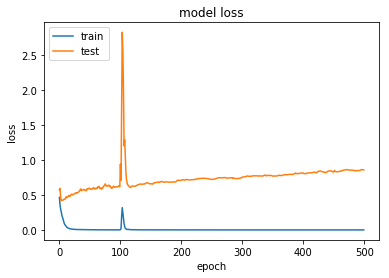

In [13]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

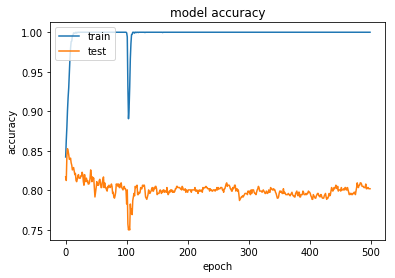

In [14]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [16]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/vishnu/NN/model_CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 85.42%


In [17]:
preds = loaded_model.predict(x_test, batch_size=32, verbose=1)

96/96 [==============================] - 0s 4ms/step


In [18]:
preds

array([[0.15165725, 0.03467991, 0.10866404, 0.18313482, 0.14526974,
        0.27731758, 0.0992767 ],
       [0.14368801, 0.09853927, 0.08647908, 0.07076237, 0.16260882,
        0.32721946, 0.11070304],
       [0.29135647, 0.13671218, 0.03087269, 0.12428001, 0.3159751 ,
        0.04940001, 0.05140352],
       [0.18531586, 0.11176945, 0.07695587, 0.08647907, 0.32831544,
        0.11674894, 0.09441542],
       [0.18468638, 0.15083055, 0.23085216, 0.0663793 , 0.10371275,
        0.18692102, 0.07661778],
       [0.17239648, 0.09827963, 0.15983377, 0.27095327, 0.09136198,
        0.03871011, 0.16846478],
       [0.0707662 , 0.01053482, 0.02882346, 0.09922901, 0.748533  ,
        0.01864486, 0.02346869],
       [0.11946622, 0.0929264 , 0.06139336, 0.13476036, 0.28527173,
        0.06097357, 0.24520831],
       [0.11764186, 0.11035454, 0.14021365, 0.14312112, 0.12161437,
        0.19067824, 0.17637622],
       [0.25635183, 0.07025652, 0.15550423, 0.1467635 , 0.1491078 ,
        0.08146784, 0.1

In [19]:
preds1=preds.argmax(axis=1)

In [69]:
preds2 = np.argsort(preds, axis=1)

In [70]:
preds2[:,-2]

array([3, 4, 0, 0, 5, 0, 3, 6, 6, 2, 6, 5, 6, 5, 0, 5, 4, 2, 5, 2, 3, 6,
       2, 4, 0, 3, 2, 6, 4, 0, 5, 5, 2, 3, 1, 4, 0, 4, 0, 0, 0, 4, 0, 2,
       1, 5, 6, 3, 3, 0, 1, 6, 2, 3, 0, 1, 5, 1, 2, 0, 4, 4, 4, 1, 0, 3,
       2, 2, 0, 3, 1, 0, 2, 0, 0, 5, 2, 0, 4, 0, 2, 5, 1, 6, 6, 4, 2, 0,
       1, 0, 3, 3, 1, 1, 2, 5])

In [20]:
preds1

array([5, 5, 4, 4, 2, 3, 4, 4, 5, 0, 5, 1, 4, 4, 6, 4, 0, 3, 0, 0, 6, 2,
       4, 3, 4, 4, 1, 0, 0, 4, 0, 0, 4, 4, 4, 1, 4, 0, 5, 4, 4, 6, 4, 4,
       5, 4, 2, 0, 2, 5, 0, 4, 4, 2, 4, 3, 0, 4, 5, 3, 1, 0, 2, 4, 6, 0,
       4, 3, 4, 1, 4, 4, 4, 5, 5, 0, 4, 4, 0, 4, 6, 4, 6, 0, 0, 0, 5, 4,
       4, 4, 6, 4, 4, 5, 5, 0])

In [71]:
abc2 = preds2.astype(int).flatten()

In [21]:
abc = preds1.astype(int).flatten()

In [72]:
predictions2 = (lb.inverse_transform((abc2)))

In [22]:
predictions = (lb.inverse_transform((abc)))

In [73]:
preddf2 = pd.DataFrame({'2nd best predictedvalues': predictions2})
preddf2[:10]

,2nd best predictedvalues
0,1
1,6
2,2
3,4
4,0
5,3
6,5
7,3
8,2
9,1


In [23]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,5
1,5
2,4
3,4
4,2
5,3
6,4
7,4
8,5
9,0


In [24]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [25]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,1
1,5
2,5
3,4
4,5
5,2
6,4
7,5
8,1
9,6


In [26]:
finaldf = actualdf.join(preddf)

In [27]:
finaldf[30:50]

,actualvalues,predictedvalues
30,5,0
31,0,0
32,5,4
33,6,4
34,5,4
35,1,1
36,4,4
37,2,0
38,6,5
39,0,4


In [74]:
final = finaldf.join(preddf2)

In [76]:
final[30:50]

,actualvalues,predictedvalues,2nd best predictedvalues
30,5,0,4
31,0,0,1
32,5,4,0
33,6,4,5
34,5,4,2
35,1,1,5
36,4,4,4
37,2,0,1
38,6,5,2
39,0,4,6


In [28]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,12
1,17
2,8
3,10
4,23
5,11
6,15


In [29]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,20
1,5
2,6
3,6
4,39
5,13
6,7


In [30]:
finaldf = actualdf.join(preddf)

In [82]:
import wave

In [83]:
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)
print("* recording")
frames = []
for i in range(0, int(44100 / 1024 * 4)):
    data = stream.read(1024)
    frames.append(data)
print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open("output.wav", 'wb')
wf.setnchannels(1)
wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
wf.setframerate(44100)
wf.writeframes(b''.join(frames))
wf.close()


* recording
* done recording


In [84]:
testdata = []
mfcc_len=39
max_fs = 0
min_sample = int('9' * 10)
s = 0
cnt = 0
fs, signal = read_wav("output.wav")
fs1, signal1 = read_wav("1.wav")
max_fs = max(max_fs, fs)
s_len = len(signal)
if s_len < mslen:
    pad_len = mslen - s_len
    pad_rem = pad_len % 2
    pad_len /= 2
    signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values=0)
else:
    pad_len = s_len - mslen
    pad_rem = pad_len % 2
    pad_len /= 2
    signal = signal[int(pad_len):int(pad_len) + mslen]
min_sample = min(len(signal), min_sample)
mfcc = speechpy.feature.mfcc(signal, fs, num_cepstral=mfcc_len)

mfcc = mfcc.flatten()
testdata.append(mfcc)
testdata = testdata[0][0:2730]
xshape = (70, 39)
testdata = np.array(testdata)
testdata = testdata.reshape(xshape)
listk = np.array(testdata)

In [90]:
in_shape1 = listk.shape
print(in_shape1)
testdata = testdata.reshape(1, in_shape1[0], in_shape1[1], 1)

(70, 39)


In [91]:
tally = model.predict(testdata)

In [92]:
print((tally))

[[0.02342437 0.47165182 0.06639561 0.02513868 0.40918267 0.00063977
  0.0035672 ]]
